In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.append("../src")
from sklearn.model_selection import train_test_split

In [2]:
from model.train import train_model
from model.model_utils import export_model
from feature_selector import select_features
from data_loader import load_dataset, export_dataset
from plotting.plot_utils import plot_r2_depth_profile, plot_feature_importance, plot_bbp_profiles, \
plot_relative_error, plot_validation_scatter
from model.model_metrics import overall_metrics, save_overall_metrics, depth_metrics, overall_validation_metrics, \
save_overall_validation_metrics,depth_val_metrics
from utils import start_experiments, ExportConfig, ExperimentSetup, prepare_xy, log10_to_bbp

# Single Experiment Walkthrough

This notebook runs a single experiment configuration for a specific region, depth, and feature set. It includes:

- Data loading and preprocessing
- Model training
- Validation and metric computation
- Scatter and profile plots
- Optional export of results
  

## Experiments Overview

Each experiment corresponds to a different configuration of satellite-derived inputs used in combination (or not) with BGC-Argo data to estimate the bbp profiles

| **Experiment** | **Input Source(s)**                               | **Description**                                                                                                            |
| -------------- | ------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------- |
| `GCGOBGC`      | **GlobColour + SLA + BGC-Argo**                   | Combines reflectances from the GlobColour product and Sea Level Anomaly (SLA) with in situ BGC-Argo float profiles.        |
| `S3OLCIBGC`    | **Sentinel-3 OLCI reflectance + BGC-Argo** | Uses OLCI Level-2 reflectances with BGC-Argo float data. |
| `S3IOPS`       | **Sentinel-3 OLCI + IOPs**                     | Uses OLCI data and Inherent Optical Properties (IOPs, retrieved via C2RCC) with Argo data.                                       |
| `S3OLCI`       | **Sentinel-3 OLCI reflectances only**             | Uses only the reflectances from Sentinel-3 OLCI (no IOPs or Argo data).                                      |


In [3]:
print(f"Regions:{ExperimentSetup.ALL_REGIONS}") 
print(f"Depths:{ExperimentSetup.ALL_DEPTHS}") 
print(f"Experiments:{ExperimentSetup.ALL_EXPERIMENTS}") 

Regions:['NA', 'STG']
Depths:['50', '250']
Experiments:['GCGOBGC', 'S3OLCIBGC', 'S3IOPS', 'S3OLCI']


#### Configure experiment and export settings

In [4]:
setup = ExperimentSetup(region="NA", depth="250", experiment="GCGOBGC")

In [5]:
print(f"{setup}")
print(f"Validation float = {setup.validation_float()}")

ExperimentSetup(region='NA', depth='250', experiment='GCGOBGC')
Validation float = 6902671


Configure exports

In [6]:
exports = ExportConfig(export_datasets=True, 
                         export_model=True, 
                         export_model_metrics=True, 
                         export_fig_depth=True, 
                         export_fig_profile=True, 
                         export_fig_importance=True, 
                         export_validation_metrics=True, 
                         export_fig_val=True)

In [7]:
start_experiments()

Folders are configured.


### Dataset

In [8]:
train, validation = load_dataset(setup)

In [9]:
print(f"Training set = {train.shape[0]} samples")
print(f"Input features = {train.shape[1]}")
print(f"Validation set = {validation.shape[0]}")

Training set = 376 samples
Input features = 218
Validation set = 35


In [10]:
# Export Train and Validation
export_dataset(train, validation, setup) if exports.export_datasets else None

Data exported to: ../datasets/training/Train_NA_250_GCGOBGC.txt and ../datasets/validation/Validation_NA_250_GCGOBGC.txt


In [11]:
# Select features according to setup
dataset_features, bbp_outputs = select_features(train, setup)

### Model development

In [12]:
# Prepare Training data
X, y_log = prepare_xy(train, dataset_features, bbp_outputs)

In [13]:
# Train/Test split
x_train, x_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=1)

In [14]:
# Model training
model = train_model(x_train, y_train_log)

In [15]:
# Model inference
y_pred_log = model.predict(x_test)

In [16]:
# Convert outputs from log10 to bbp
y_pred_bbp = log10_to_bbp(y_pred_log)
y_test_bbp = log10_to_bbp(y_test_log)

In [17]:
# Export model
export_model(model, setup) if exports.export_model else None

Model saved to: ../results/NA/250/GCGOBGC/Model/NA_250_GCGOBGC_model.sav


###  Evaluation Metrics

In [18]:
ov_metrics = overall_metrics(y_test_bbp,y_pred_bbp)

In [19]:
print(f"Overall metrics for {setup.region, setup.depth, setup.experiment}:")
ov_metrics

Overall metrics for ('NA', '250', 'GCGOBGC'):


{'R2': 0.8393129506912914,
 'MSE': 7.086136496335442e-08,
 'MAE': 8.508718915518776e-05,
 'RMSE': 0.00018162874587945987,
 'MAPD': np.float64(3.3702087481542002)}

In [20]:
save_overall_metrics(ov_metrics,setup)if exports.export_model_metrics else None

Saved overall metrics to ../results/NA/250/GCGOBGC/Model/Metrics


In [21]:
depth_metrics_df = depth_metrics(y_test_bbp,y_pred_bbp, setup)

In [22]:
depth_metrics_df.to_csv(f"../results/{setup.region}/{setup.depth}/{setup.experiment}/Model/Metrics/\
{setup.region}_{setup.depth}_{setup.experiment}_depth_metrics.csv")if exports.export_model_metrics else None

### Plots

#### Depth-resoloved R²

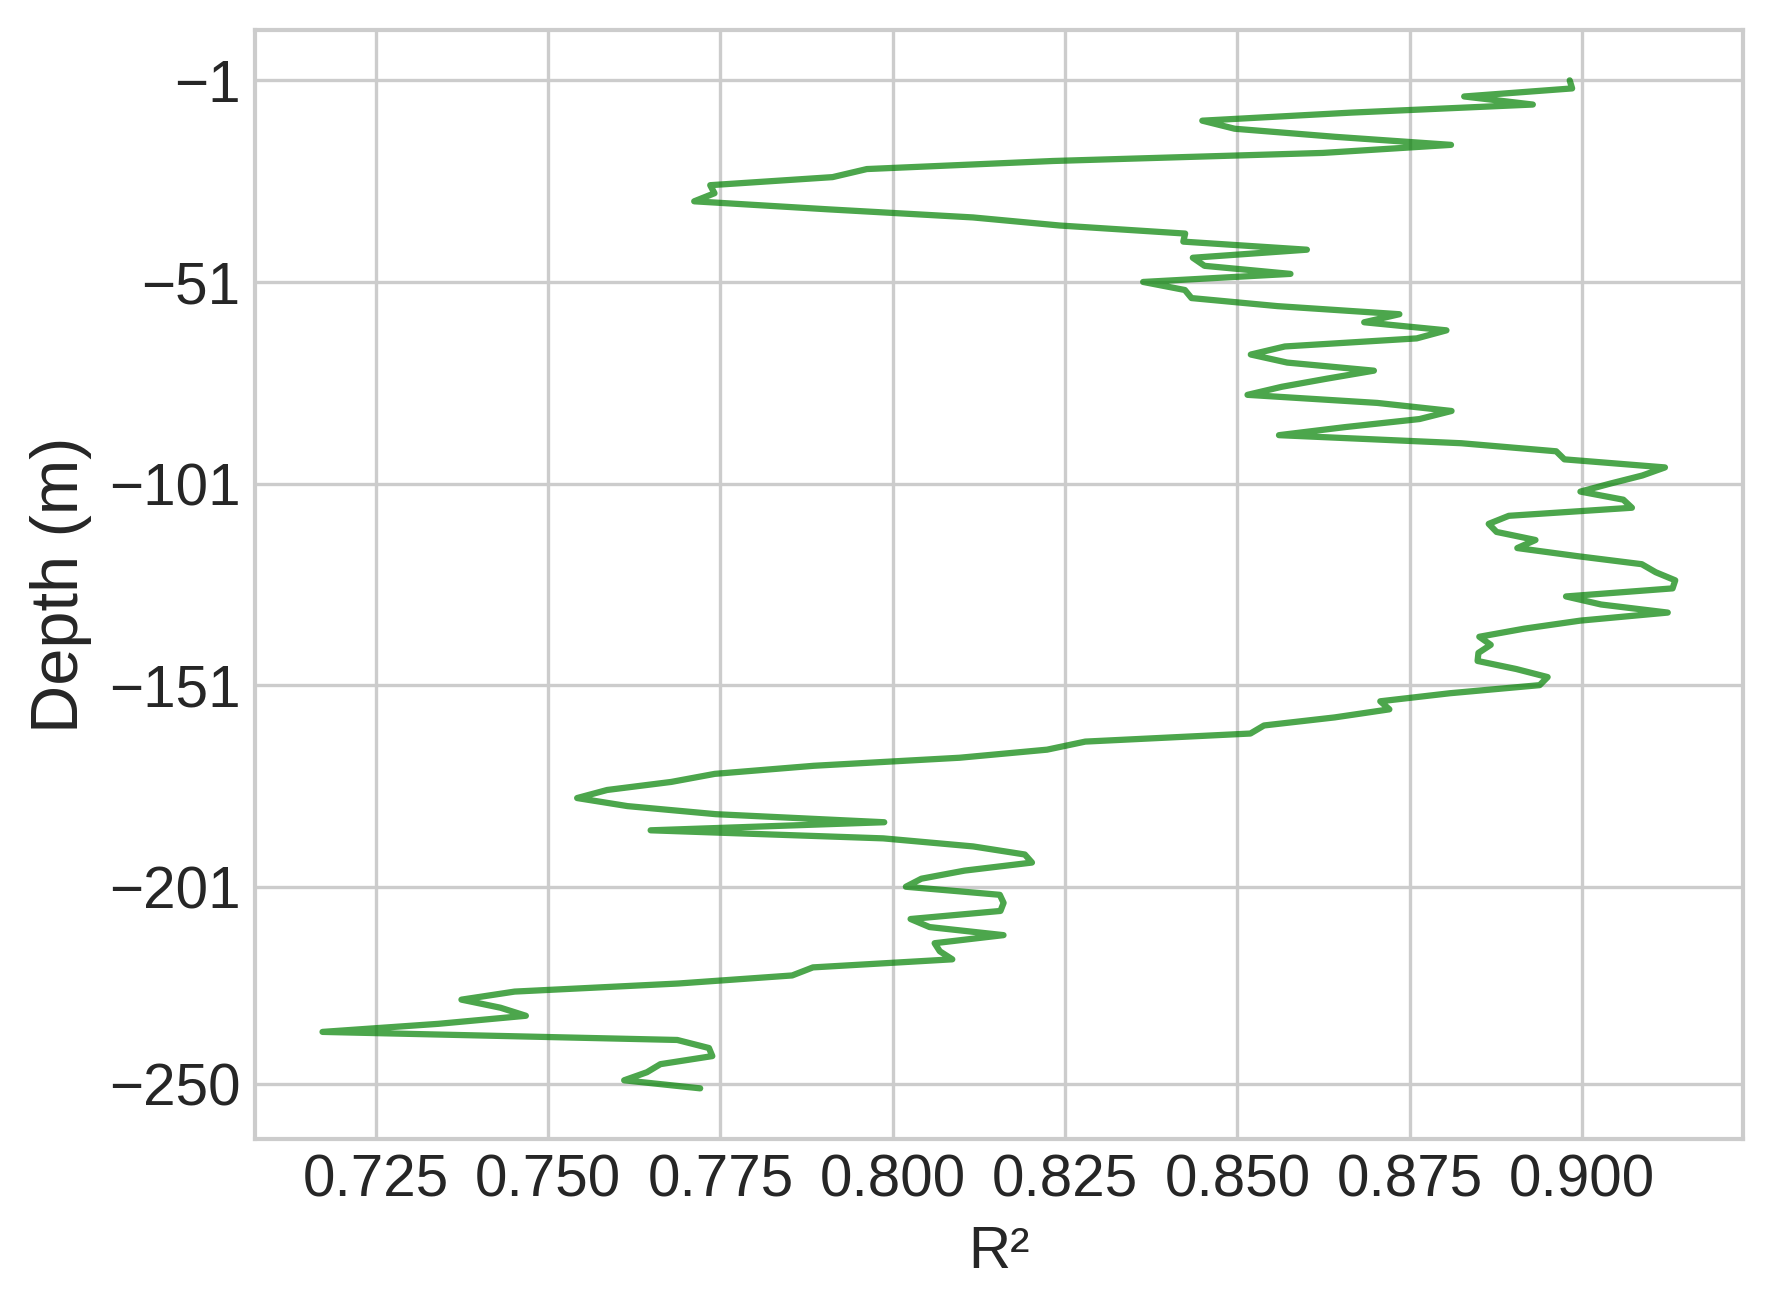

In [23]:
plot_r2_depth_profile(depth_metrics_df, setup,exports)

#### Model Feature Importance

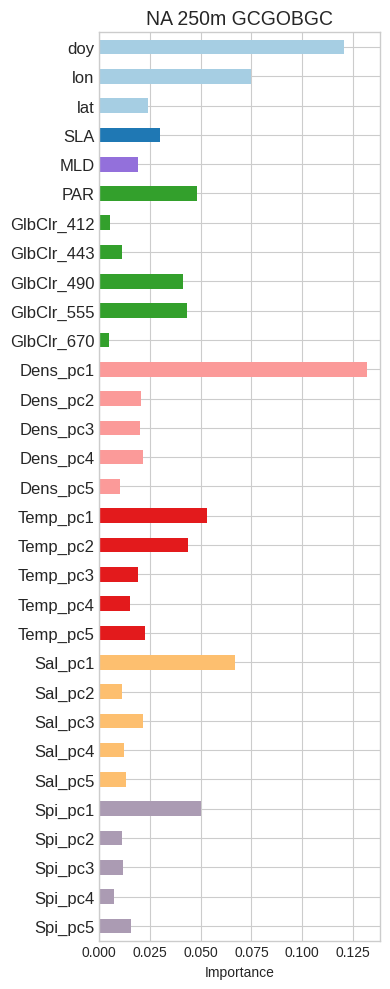

In [24]:
plot_feature_importance(model,x_train, setup, exports)

#### Bbp Profiles

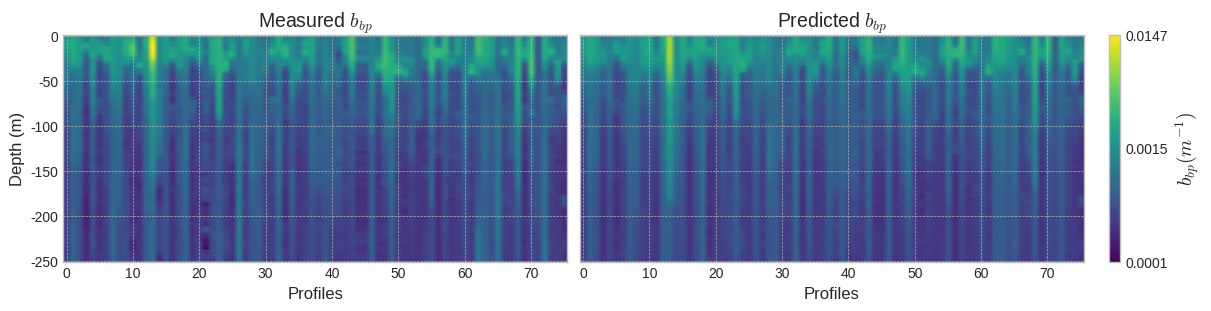

In [25]:
plot_bbp_profiles(y_test_bbp, y_pred_bbp, setup, exports)

#### Relative Error

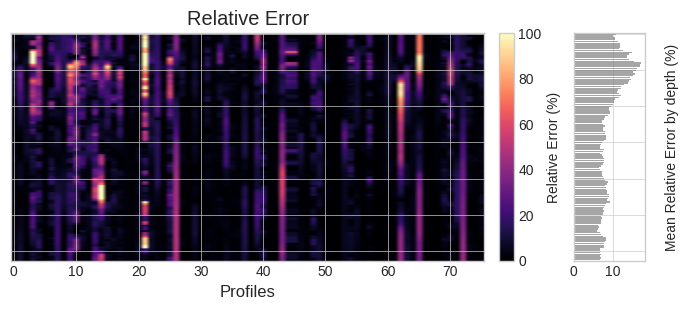

In [26]:
plot_relative_error(y_test_bbp, y_pred_bbp, setup, exports)

## Validation

In [27]:
# Prepare validation data
x_val, y_val_log= prepare_xy(validation, dataset_features, bbp_outputs)

In [28]:
# Model inference
y_pred_val_log = model.predict(x_val)

In [29]:
# Convert outputs from log10 to bbp
y_pred_val_bbp = log10_to_bbp(y_pred_val_log)
y_val_bbp = log10_to_bbp(y_val_log)

#### Validation metrics

In [30]:
# Overall Metrics
ov_metrics_val = overall_validation_metrics(y_val_bbp,y_pred_val_bbp)

In [31]:
ov_metrics_val

{'R2': 0.3194348604869012,
 'MSE': 3.24074549275918e-08,
 'MAE': 7.496110627222892e-05,
 'RMSE': 0.00010400053672637215,
 'MAPD': np.float64(6.563573437658086)}

In [32]:
# Export metrics
save_overall_validation_metrics(y_val_bbp, y_pred_val_bbp,setup, exports)

Saved overall validation metrics to: ../results/NA/250/GCGOBGC/Validation/Metrics/NA_250_GCGOBGC_Val_overall_metrics.csv


In [33]:
# Depth-resolved metrics
depth_val_metrics_df = depth_val_metrics(y_val_bbp, y_pred_val_bbp, setup)

### Validation scatter plot

<Figure size 800x800 with 0 Axes>

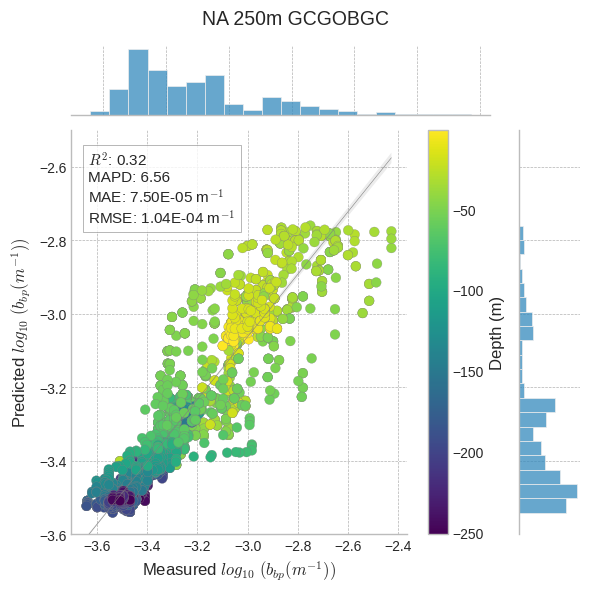

In [34]:
plot_validation_scatter(depth_val_metrics_df, y_val_log, y_pred_val_log, setup, exports)